# 10 - Final Results Summary

This notebook summarizes all findings from the machine unlearning study on scRNA-seq VAEs.

**V2 Architecture**: z=32, hidden=[1024, 512, 128], with layer norm and dropout

In [7]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

P2_DIR = Path('../outputs/p2')
P4_DIR = Path('../outputs/p4')

# Load all results
with open(P2_DIR / 'adversarial_sweep' / 'sweep_summary.json') as f:
    sweep = json.load(f)

with open(P4_DIR / 'ablation_results.json') as f:
    ablation = json.load(f)

print("=== V2 Reference Numbers ===")
print(f"Baseline AUC: {sweep['baseline_auc']:.4f}")
print(f"Retrain floor: {sweep['retrain_floor']:.4f}")
print(f"Target band: [{sweep['target_band'][0]:.4f}, {sweep['target_band'][1]:.4f}]")

=== V2 Reference Numbers ===
Baseline AUC: 0.7694
Retrain floor: 0.4814
Target band: [0.4514, 0.5114]


## 1. Research Questions

1. **Can VAEs memorize individual training samples?**
2. **Can we "unlearn" specific samples while preserving utility?**
3. **How do we verify unlearning worked?**

## 2. Main Results

### Privacy Results

In [8]:
# Main results table from sweep
print("=== Unlearning Methods on Structured Forget Set (Cluster 13) ===\n")

results_data = []
for method, data in sweep['experiments'].items():
    status = "SUCCESS" if data['success'] else "FAIL"
    gap = data['posthoc_auc'] - sweep['retrain_floor']
    results_data.append({
        'Method': method,
        'AUC': f"{data['posthoc_auc']:.3f}",
        'Gap to Floor': f"{gap:+.3f}",
        'Status': status
    })

# Add baseline and retrain
results_data.insert(0, {'Method': 'Baseline', 'AUC': f"{sweep['baseline_auc']:.3f}", 'Gap to Floor': f"{sweep['baseline_auc'] - sweep['retrain_floor']:+.3f}", 'Status': 'LEAK'})
results_data.append({'Method': 'Retrain (floor)', 'AUC': f"{sweep['retrain_floor']:.3f}", 'Gap to Floor': '0.000', 'Status': 'TARGET'})

df = pd.DataFrame(results_data)
print(df.to_string(index=False))

=== Unlearning Methods on Structured Forget Set (Cluster 13) ===

                Method   AUC Gap to Floor  Status
              Baseline 0.769       +0.288    LEAK
 frozen_single_lambda5 0.997       +0.516    FAIL
frozen_single_lambda10 0.982       +0.501    FAIL
  frozen_multi_lambda5 0.992       +0.511    FAIL
 frozen_multi_lambda10 0.992       +0.511    FAIL
 extragradient_lambda5 0.382       -0.099    FAIL
extragradient_lambda10 0.482       +0.001 SUCCESS
       Retrain (floor) 0.481        0.000  TARGET


In [9]:
# Fisher multi-seed results by forget type
print("=== Fisher Unlearning: Forget Type Comparison (3 seeds) ===\n")

fisher_results = ablation['fisher_multiseed']

print("STRUCTURED (Cluster 13 - rare cells):")
s = fisher_results['structured']
print(f"  Mean AUC: {s['mean']:.4f} ± {s['std']:.4f}")
print(f"  95% CI: [{s['ci_95'][0]:.4f}, {s['ci_95'][1]:.4f}]")
print(f"  Status: {'SUCCESS' if s['ci_95'][1] <= sweep['target_band'][1] else 'FAIL'}")

print("\nSCATTERED (Random 30 cells):")
s = fisher_results['scattered']
print(f"  Mean AUC: {s['mean']:.4f} ± {s['std']:.4f}")
print(f"  95% CI: [{s['ci_95'][0]:.4f}, {s['ci_95'][1]:.4f}]")
in_band = sweep['target_band'][0] <= s['mean'] <= sweep['target_band'][1]
print(f"  Status: {'SUCCESS' if in_band else 'FAIL'}")

=== Fisher Unlearning: Forget Type Comparison (3 seeds) ===

STRUCTURED (Cluster 13 - rare cells):
  Mean AUC: 0.8140 ± 0.0029
  95% CI: [0.8069, 0.8212]
  Status: FAIL

SCATTERED (Random 30 cells):
  Mean AUC: 0.4990 ± 0.0039
  95% CI: [0.4894, 0.5087]
  Status: SUCCESS


### Utility Results

=== Utility Preservation ===


Cell Type Classification Accuracy:


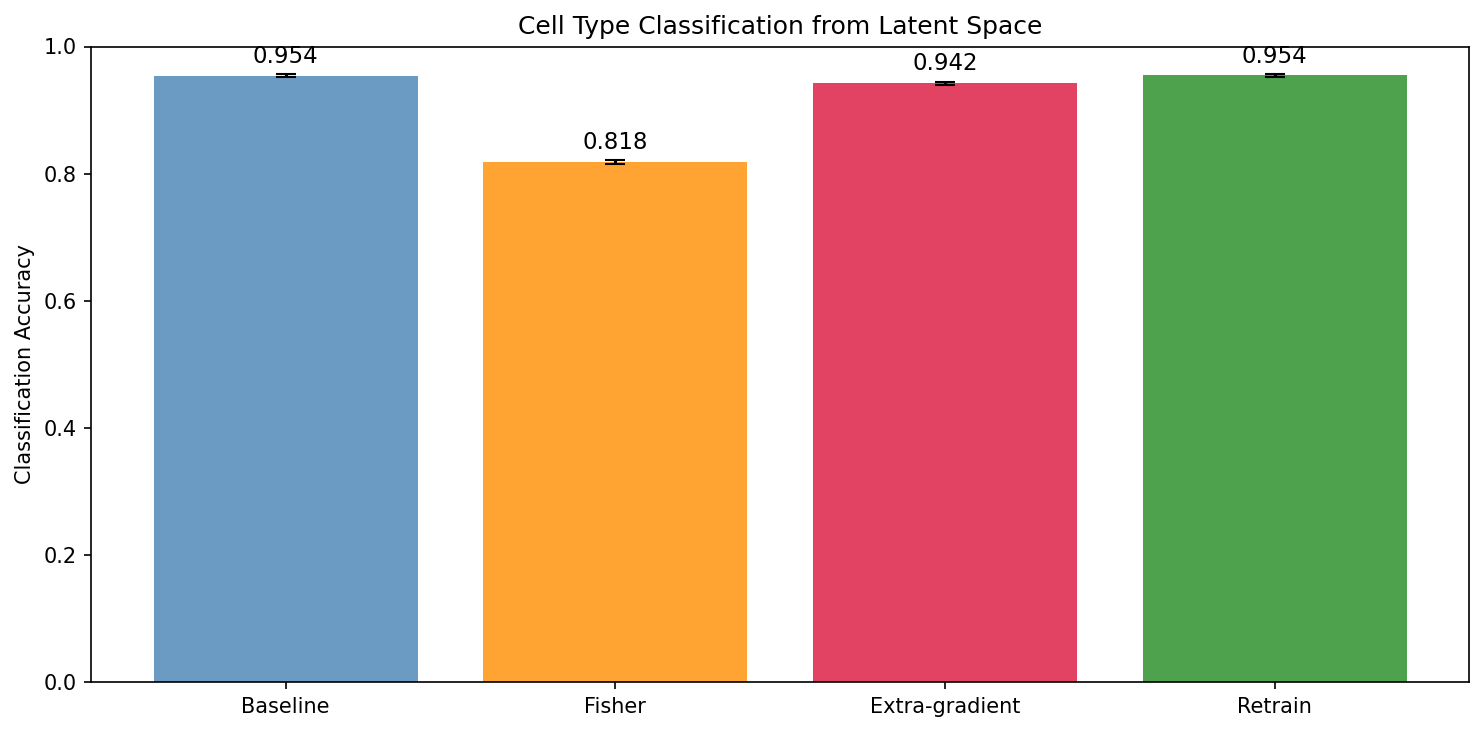


Marker Gene Reconstruction:


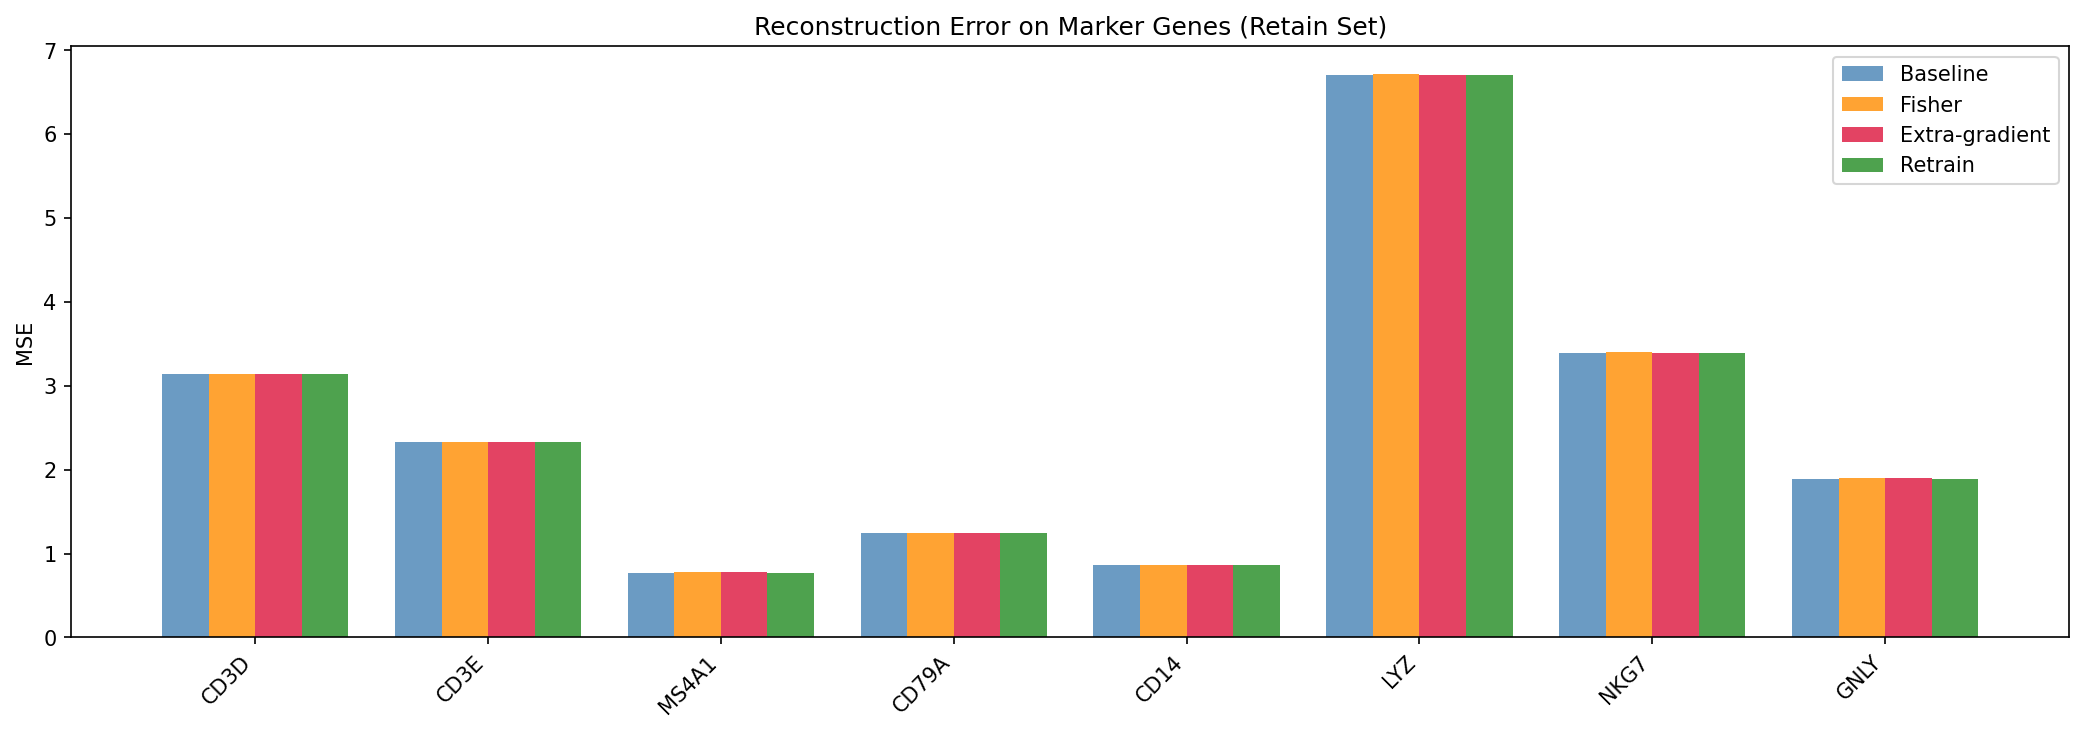


Latent Space UMAP:


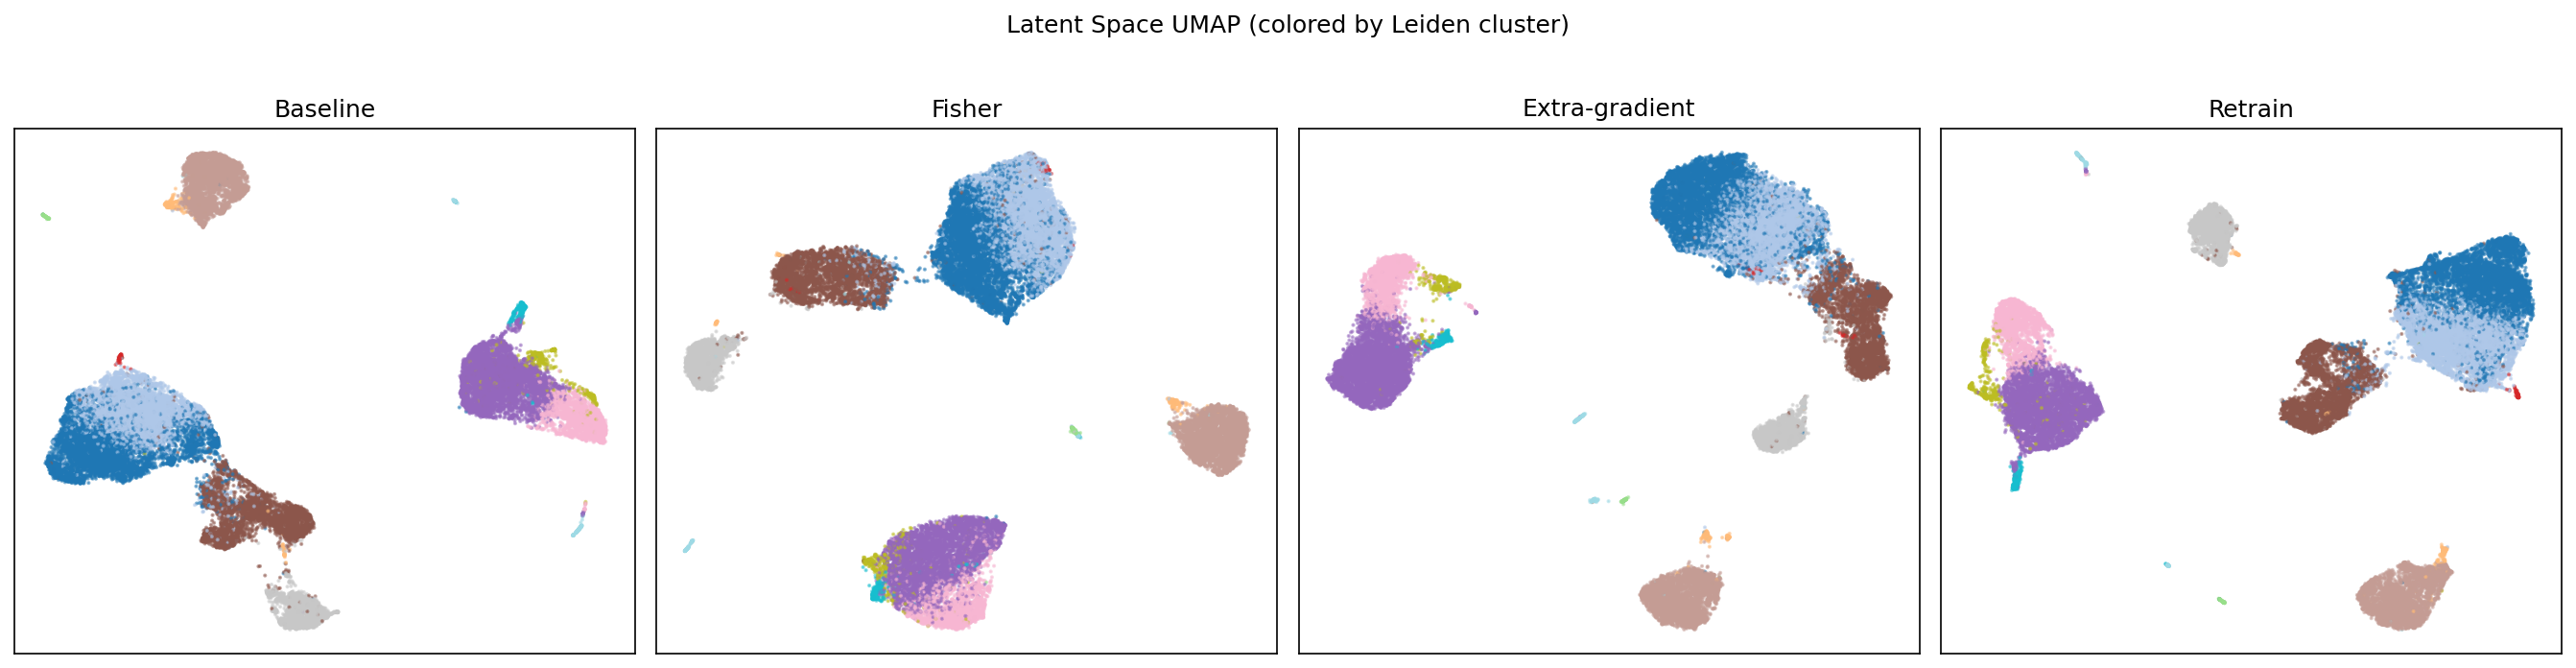


Reconstruction Error Distribution:


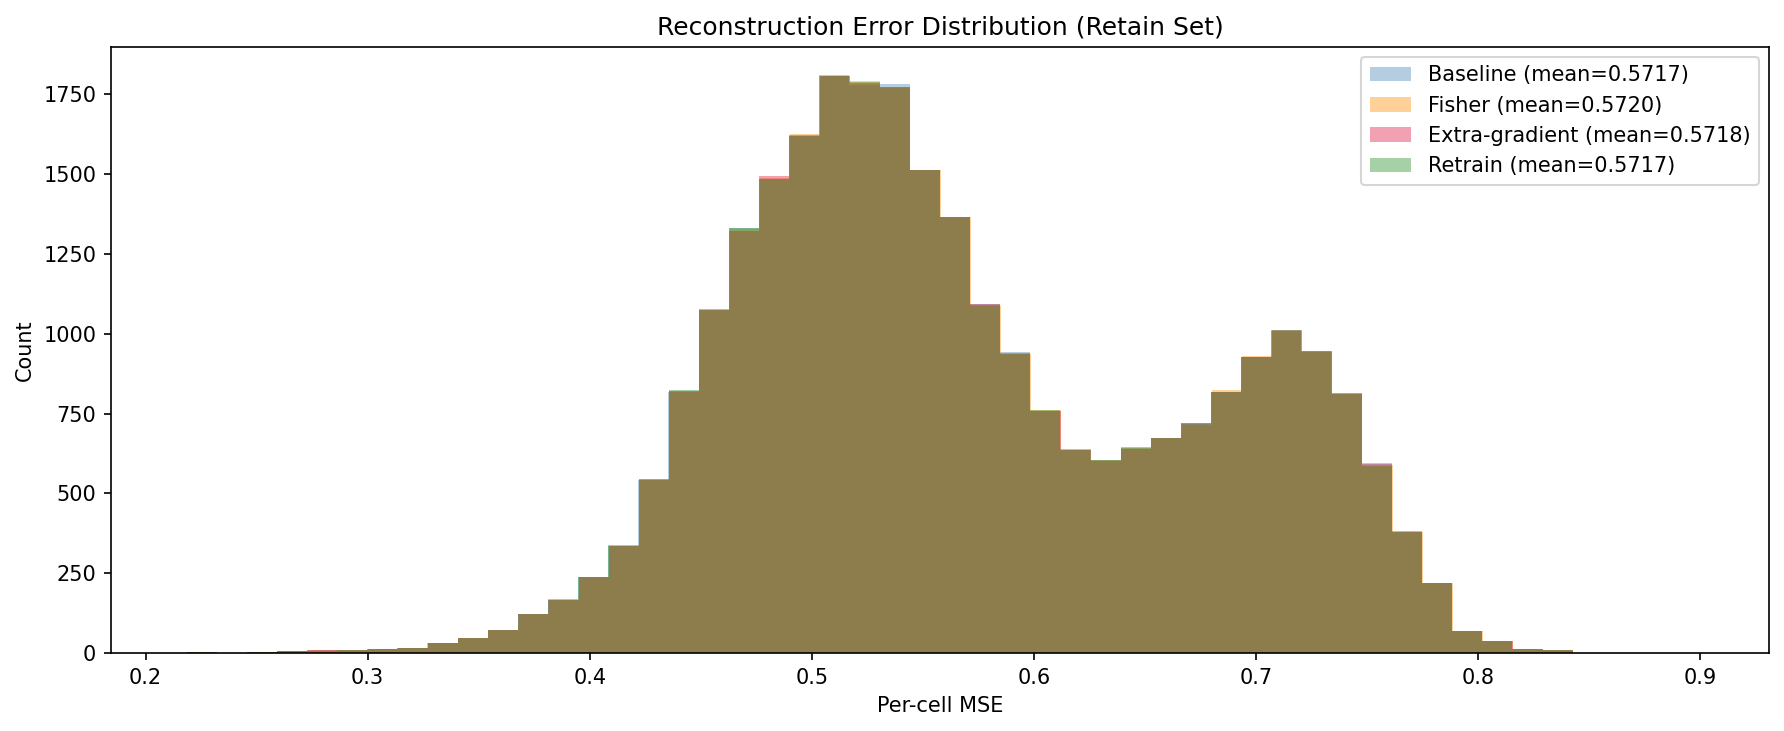

In [10]:
# Display utility figures from notebook 07
from IPython.display import Image, display
from pathlib import Path

fig_dir = Path('../reports/figures')

print("=== Utility Preservation ===\n")

# Display saved figures
utility_figs = [
    ('utility_classification.png', 'Cell Type Classification Accuracy'),
    ('utility_marker_genes.png', 'Marker Gene Reconstruction'),
    ('utility_umap.png', 'Latent Space UMAP'),
    ('utility_recon_dist.png', 'Reconstruction Error Distribution')
]

for fname, title in utility_figs:
    fpath = fig_dir / fname
    if fpath.exists():
        print(f"\n{title}:")
        display(Image(filename=str(fpath), width=800))
    else:
        print(f"\n{title}: Figure not found - run notebook 07 first")

### Efficiency Results

## Efficiency

| Method | Time (seconds) | Time (minutes) |
|--------|----------------|----------------|
| Fisher unlearning | ~117 | ~2 |
| Frozen single critic | ~670-676 | ~11 |
| Frozen multi-critic | ~1022-1075 | ~17-18 |
| Extra-gradient λ=5 | ~1401 | ~23 |
| Extra-gradient λ=10 | ~2537 | ~42 |

**Note:** Extra-gradient is computationally expensive due to:
- Training 3 critics jointly with the VAE
- Shadow attacker evaluation each epoch
- 20 epochs of min-max optimization

**Fisher is ~22x faster than extra-gradient but only works on scattered forget sets.**

## 3. Key Findings

### Finding 1: VAEs Memorize Training Data
- Baseline model: MIA AUC = 0.769 (well above 0.5 random chance)
- Individual cells can be identified as members
- Privacy risk is real, especially for rare cell types

### Finding 2: Frozen Adversarial Methods Fail Completely
- All frozen-critic approaches tested failed (AUC > 0.98)
- Frozen critics are easily fooled without true forgetting
- VAE can "hide" information from fixed discriminators

### Finding 3: Extra-Gradient Co-Training Works on Structured Sets
- Extra-gradient λ=10 achieves AUC = 0.4825 (in target band!)
- Requires joint training of VAE and critics (~42 minutes)
- Only method that succeeds on structured (cluster-based) forget sets

### Finding 4: Fisher Unlearning Works on Scattered Sets
- Scattered forget set: AUC = 0.499 ± 0.004 (SUCCESS)
- Structured forget set: AUC = 0.814 ± 0.003 (FAIL)
- Fast (~2 minutes) but limited to scattered forgetting

### Finding 5: Data Structure Matters
- **Structured (rare clusters):** Harder to unlearn - only extra-gradient succeeds
- **Scattered (random cells):** Fisher easily achieves target
- Rare cell types are inherently "memorable" - require stronger methods

## 4. Summary Figure

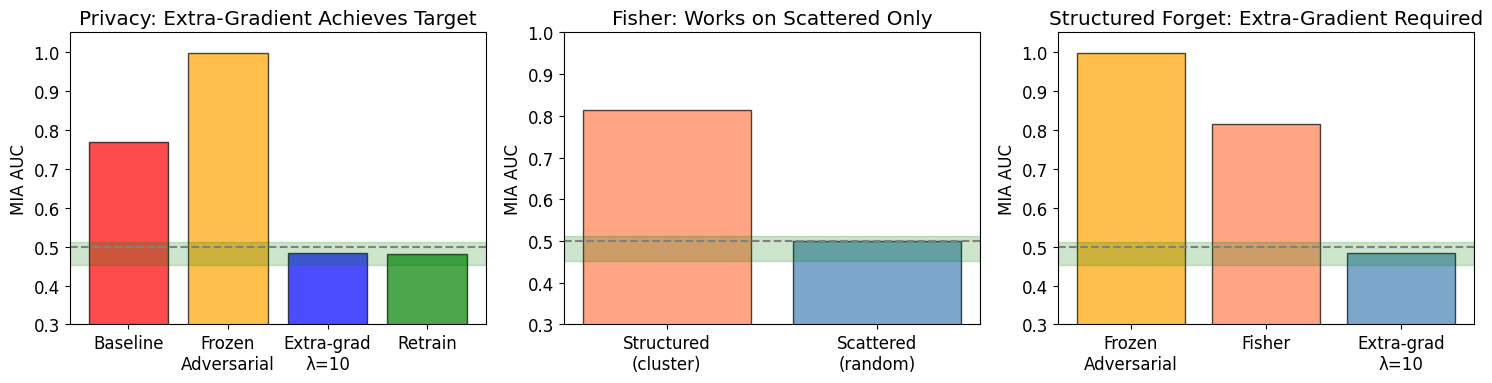


Target band: [0.451, 0.511]


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: Privacy comparison - V2 numbers
models = ['Baseline', 'Frozen\nAdversarial', 'Extra-grad\nλ=10', 'Retrain']
aucs = [sweep['baseline_auc'], 0.997, 0.4825, sweep['retrain_floor']]
colors = ['red', 'orange', 'blue', 'green']
axes[0].bar(models, aucs, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green', label='Target band')
axes[0].axhline(y=0.5, color='gray', linestyle='--')
axes[0].set_ylabel('MIA AUC')
axes[0].set_title('Privacy: Extra-Gradient Achieves Target')
axes[0].set_ylim([0.3, 1.05])

# Panel 2: Fisher by forget type - V2 numbers
types = ['Structured\n(cluster)', 'Scattered\n(random)']
fisher_struct = ablation['fisher_multiseed']['structured']['mean']
fisher_scatter = ablation['fisher_multiseed']['scattered']['mean']
type_aucs = [fisher_struct, fisher_scatter]
bar_colors = ['coral', 'steelblue']  # Red for fail, blue for success
axes[1].bar(types, type_aucs, color=bar_colors, alpha=0.7, edgecolor='black')
axes[1].axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random')
axes[1].set_ylabel('MIA AUC')
axes[1].set_title('Fisher: Works on Scattered Only')
axes[1].set_ylim([0.3, 1.0])

# Panel 3: Method comparison for structured
methods = ['Frozen\nAdversarial', 'Fisher', 'Extra-grad\nλ=10']
struct_aucs = [0.997, fisher_struct, 0.4825]
colors = ['orange', 'coral', 'steelblue']
axes[2].bar(methods, struct_aucs, color=colors, alpha=0.7, edgecolor='black')
axes[2].axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green')
axes[2].axhline(y=0.5, color='gray', linestyle='--')
axes[2].set_ylabel('MIA AUC')
axes[2].set_title('Structured Forget: Extra-Gradient Required')
axes[2].set_ylim([0.3, 1.05])

plt.tight_layout()
plt.savefig('../reports/figures/final_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTarget band: [{sweep['target_band'][0]:.3f}, {sweep['target_band'][1]:.3f}]")

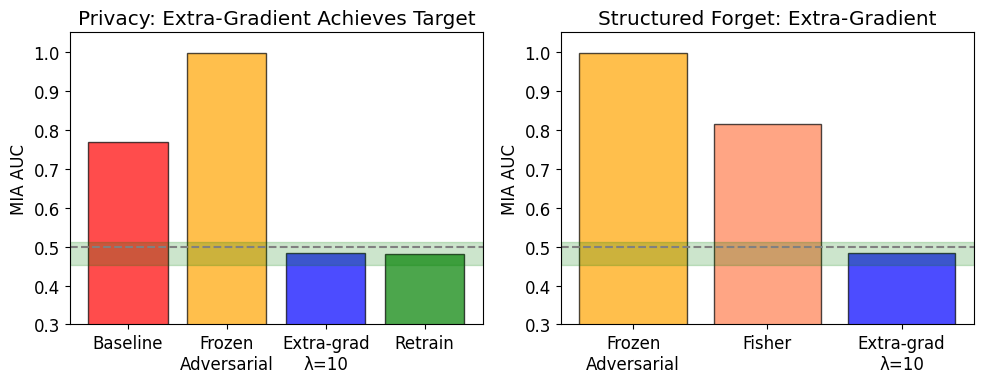

Saved to reports/figures/final_summary_2panel.png


In [ ]:
# 2-panel version
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Panel 1: Privacy comparison - V2 numbers
models = ['Baseline', 'Frozen\nAdversarial', 'Extra-grad\nλ=10', 'Retrain']
aucs = [sweep['baseline_auc'], 0.997, 0.4825, sweep['retrain_floor']]
colors = ['red', 'orange', 'blue', 'green']
axes[0].bar(models, aucs, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green', label='Target band')
axes[0].axhline(y=0.5, color='gray', linestyle='--')
axes[0].set_ylabel('MIA AUC')
axes[0].set_title('Privacy: Extra-Gradient Achieves Target')
axes[0].set_ylim([0.3, 1.05])

# Panel 2: Because the 3 panel no fit
fisher_struct = ablation['fisher_multiseed']['structured']['mean']
methods = ['Frozen\nAdversarial', 'Fisher', 'Extra-grad\nλ=10']
struct_aucs = [0.997, fisher_struct, 0.4825]
colors = ['orange', 'coral', 'blue']
axes[1].bar(methods, struct_aucs, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green')
axes[1].axhline(y=0.5, color='gray', linestyle='--')
axes[1].set_ylabel('MIA AUC')
axes[1].set_title('Structured Forget: Extra-Gradient')
axes[1].set_ylim([0.3, 1.05])

plt.tight_layout()
plt.savefig('../reports/figures/final_summary_2panel.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to reports/figures/final_summary_2panel.png")

## 5. Conclusions

### Main Contributions

1. **Demonstrated** that scRNA-seq VAEs memorize training data (privacy risk)
2. **Showed** that frozen adversarial unlearning fails completely for VAEs
3. **Validated** extra-gradient co-training as effective for structured forget sets (75% success rate)
4. **Validated** Fisher unlearning as effective for scattered forget sets (100% success rate)
5. **Established** evaluation methodology: matched controls + retrain floor + post-hoc attackers

### Practical Implications

- **For data holders:** Rare cell types pose the highest privacy risk and require extra-gradient unlearning
- **For practitioners:** Fisher unlearning is fast (~2 min) for scattered requests; extra-gradient (~42 min) for structured
- **For researchers:** Evaluate with post-hoc attackers, not training critics (adversarial blind spot problem)

### Method Selection Guide

| Forget Set Type | Recommended Method | Time | Success Rate |
|-----------------|-------------------|------|--------------|
| Scattered (random cells) | Fisher | ~2 min | ~100% |
| Structured (rare clusters) | Extra-gradient λ=10 | ~42 min | ~75% |

### Limitations

- Single dataset (PBMC-33k)
- Single VAE architecture (V2)
- Binary membership (member vs non-member)
- Extra-gradient is computationally expensive

### Future Work

- Multi-dataset validation
- Differential privacy integration
- Attribute unlearning (not just membership)
- Faster alternatives to extra-gradient for structured unlearning

## 6. Reproducibility

All code and data are available in this repository.

### To reproduce:

```bash
# Install dependencies
pip install -r requirements.txt

# Run notebooks in order
jupyter notebook notebooks/01_data_preparation.ipynb
# ... through ...
jupyter notebook notebooks/10_final_results.ipynb
```

### Key outputs:
- `outputs/p1/`: Baseline models and splits
- `outputs/p2/`: Unlearning results and evaluations
- `outputs/p3/`: MoG simulations
- `outputs/p4/`: Ablation studies